In [1]:
#TO-DO:
#- how can i ensure that the new features are also present in the test set?
    #build col dict function needs to be continued
# - do not fill with mean of class; but with mean of test set.
# move functions out of notebook into py files

import re
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#ML imports
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [3]:
#Notebook commands
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

## Tasks:

1. Read Data: For this assignment, assume input is CSV and write a function that can read a csv into python

2. Explore Data: You can use the code you wrote for assignment 1 here to generate distributions and data summaries.

3. Pre-Process Data: For this assignment, you can limit this to filling in missing values for the variables that have missing values. You can use any simple method to do it (use mean to fill in missing values).

4. Generate Features/Predictors: For this assignment, you should write one function that can discretize a continuous variable and one function that can take a categorical variable and create binary/dummy variables from it. Apply them to at least one variable each in this data.

5. Build Classifier: For this assignment, select any classifier you feel comfortable with (Logistic Regression for example)

6. Evaluate Classifier: you can use any metric you choose for this assignment (accuracy is the easiest one). Feel free to evaluate it on the same data you built the model on (this is not a good idea in general but for this assignment, it is fine). We haven't covered models and evaluation yet, so don't worry about creating validation sets or cross-validation. 

In [4]:
def read_data_from_csv(file_path, index_col=None, split=False, target=None, test_size=None):
    """
    Loads data from csv file.
    In:
        - file_path: path to csv file
        - split: (bool) split data into train & test?
        - target: column name of target
        - test_size: % of test data
    Out:
        - data: pandas Dataframe
    """
    data = pd.read_csv("data/credit-data.csv", index_col=index_col)
    
    if split:
        X_train, X_test, y_train, y_test = train_test_split(data.drop([target], axis=1), 
                                                            data[target], test_size=test_size)
        return X_train, X_test, y_train, y_test
    return data

In [5]:
X_train, X_test, y_train, y_test = read_data_from_csv("data/credit-data.csv", 0, True, "SeriousDlqin2yrs", 0.33)
data = X_train.join(y_train)

data.head()

,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
PersonID,,,,,,,,,,,,
133281,0.017636,70,60625,0,781.000000,0.0,14,0,1,0,0.0,0
128128,0.406792,36,60625,0,577.000000,NaN,6,0,0,0,0.0,0
61572,0.631340,31,60625,0,1750.000000,NaN,6,0,1,1,3.0,0
30541,0.195621,53,60625,0,0.453402,4688.0,7,0,1,0,0.0,0
97238,0.012580,56,60637,0,0.226848,19166.0,13,0,2,0,2.0,0


----
# Exploring data

In [6]:
# General description of data.
print("Dimension of train dataset: {} rows and {} features.\n".format(data.shape[0], data.shape[1]))
data.describe()

Dimension of train dataset: 100500 rows and 12 features.



,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
count,100500.000000,100500.000000,100500.000000,100500.000000,100500.000000,8.064200e+04,100500.000000,100500.000000,100500.000000,100500.000000,97893.000000,100500.000000
mean,5.873236,52.275124,60648.878716,0.432647,349.225098,6.611038e+03,8.436090,0.276667,1.015483,0.251204,0.755835,0.067114
std,212.957588,14.776837,56.912065,4.312520,1751.712188,1.350790e+04,5.133093,4.289873,1.126723,4.276527,1.114708,0.250221
min,0.000000,0.000000,60601.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.030054,41.000000,60625.000000,0.000000,0.175152,3.397000e+03,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.154900,52.000000,60629.000000,0.000000,0.366482,5.392000e+03,8.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.558056,63.000000,60644.000000,0.000000,0.866354,8.237000e+03,11.000000,0.000000,2.000000,0.000000,1.000000,0.000000
max,29110.000000,109.000000,60804.000000,98.000000,326442.000000,3.008750e+06,57.000000,98.000000,32.000000,98.000000,20.000000,1.000000


In [7]:
# What is the distribution of our target variable?
data.SeriousDlqin2yrs.value_counts()
data.SeriousDlqin2yrs.value_counts(normalize=True)

0    93755
1     6745
Name: SeriousDlqin2yrs, dtype: int64

0    0.932886
1    0.067114
Name: SeriousDlqin2yrs, dtype: float64

We are trying to predict who experiences 90 days past due delinquency or worse. In our dataset, this only occurs in 6.6% of the cases.

60625    0.222657
60601    0.111811
60637    0.111562
60804    0.111383
60629    0.111274
60618    0.111075
60657    0.110289
60644    0.109950
Name: zipcode, dtype: float64

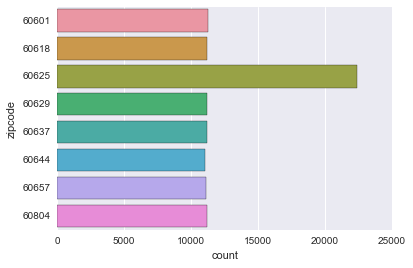

In [8]:
# Are ZIP codes equally represented?
data.zipcode.value_counts(normalize=True)
_ = sns.countplot(y="zipcode", data=data)

We only have data from 8 zip codes. The data looks equally distributed across zip codes, except for 60625 being responsible for 22% of the entries.

In [9]:
# How is our target variable distributed by ZIP code?
cross_table = pd.crosstab(data.zipcode, data.SeriousDlqin2yrs)
cross_table["total"] = cross_table[0] + cross_table[1]
cross_table["perc_of_SeriousDlqin2yrs"] = cross_table[1] / cross_table["total"]
cross_table

SeriousDlqin2yrs,0,1,total,perc_of_SeriousDlqin2yrs
zipcode,,,,
60601,10510,727,11237,0.064697
60618,10390,773,11163,0.069247
60625,20906,1471,22377,0.065737
60629,10460,723,11183,0.064652
60637,10434,778,11212,0.069390
60644,10317,733,11050,0.066335
60657,10327,757,11084,0.068297
60804,10411,783,11194,0.069948


While the ZIP code 60625 has the most entries in the dataset, the relative rate of individuals experiencing 90 days past due delinquency or worse is relatively stable across all ZIP codes.

In [10]:
# What is the mean of a variable for target = 1 and target = 0?
data.groupby("SeriousDlqin2yrs").mean()

,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
SeriousDlqin2yrs,,,,,,,,,,,
0,5.956035,52.722884,60648.808160,0.284379,353.110461,6681.657882,8.473841,0.140856,1.017290,0.131086,0.742188
1,4.722325,46.051297,60649.859451,2.493551,295.218837,5668.507027,7.911342,2.164418,0.990363,1.920830,0.943732


On average, individuals experiencing 90 days past due delinquency or worse ...
    - are younger (46.1 vs 52.75)
    - have a lower income (5684 vs 6806)
    - have a lower debt ratio (297 vs 352). However, these means are likely influenced by outliers or come from cases without monthly income/ with no reported income. Therefore, this comparison only holds if we assume that no income/no reported income shows same distribution across target variable.
    - have a lower amount of open credit lines and loans (7.86 vs 8.5)
    - have more dependents (0.96 vs 0.74)
    - have been more often 30-59/60-89/90 days past due but no worse in the last 2 years.

In [11]:
def plot_correlations(df, title):
    """
    In:
        - df: pandas dataframe
        - title: title for plot
    Out:
        -
    """
    ax = plt.axes();
    corr = df.corr()
    sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, ax=ax);
    ax.set_title(title);

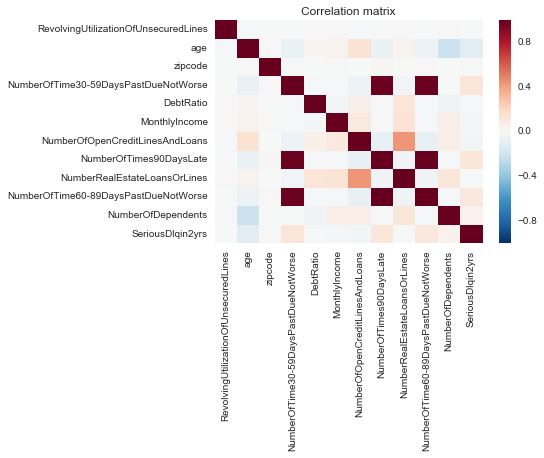

In [12]:
# How are the variables correlated with each other?
plot_correlations(data, 'Correlation matrix')

_Answer:_ 

There is a __moderate__ positive correlation between our target variable _SeriousDlqin2yrs_ and:
    - NumberOfTime30-59DaysPastDueNotWorse
    - NumberOfTime60-89DaysPastDueNotWorse
    - NumberOfTime90DaysLate
    
There is a __small__ positive correlation between our target variable _SeriousDlqin2yrs_ and:
    - NumberOfTime30-59DaysPastDueNotWorse
    - NumberOfTime60-89DaysPastDueNotWorse
    - NumberOfDependents
   
There is a __small__ negative correlation between our target variable _SeriousDlqin2yrs_ and:
    - age

----
# Pre-Processing

In [13]:
data.head()

,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
PersonID,,,,,,,,,,,,
133281,0.017636,70,60625,0,781.000000,0.0,14,0,1,0,0.0,0
128128,0.406792,36,60625,0,577.000000,NaN,6,0,0,0,0.0,0
61572,0.631340,31,60625,0,1750.000000,NaN,6,0,1,1,3.0,0
30541,0.195621,53,60625,0,0.453402,4688.0,7,0,1,0,0.0,0
97238,0.012580,56,60637,0,0.226848,19166.0,13,0,2,0,2.0,0


In [14]:
def keep_track_of_missing_values(df, missing_ind):
    """
    Adds columns indicating if original columns had 
    missing values.
    In:
        - df: pandas df
        - missing_ind: (str) indicates columns that keep track of
            missing data
    Out:
        - df: function modifies df inplace
        - list of newly created columns
    """
    new_columns = []
    
    for column in df:
        
        if df[column].isnull().values.any():
            new_col_name = column + missing_ind
            new_col = np.zeros(len(df), dtype=np.int)
            new_col[df[column].isnull()] = 1
            df[new_col_name] = new_col
            new_columns.append(new_col_name)
    return new_columns

In [15]:
 def fill_missing_values_with_mean(df, class_mean = False, key = None):
    """
    Replaces missing values with mean of class.
    In:
        - df: pandas df
        - class_mean: (bool) whether or not to use mean of class
        - key: column for classes (opt)
    Out:
        - df
    """
    if class_mean:
        key_col = df[key]
        df = df.groupby(key).transform(lambda x: x.fillna(x.mean()))
        df[key] = key_col
        return df
    else:
        return df.fillna(df.mean())

In [16]:
new_columns = keep_track_of_missing_values(data, "_missing")
data = fill_missing_values_with_mean(data)

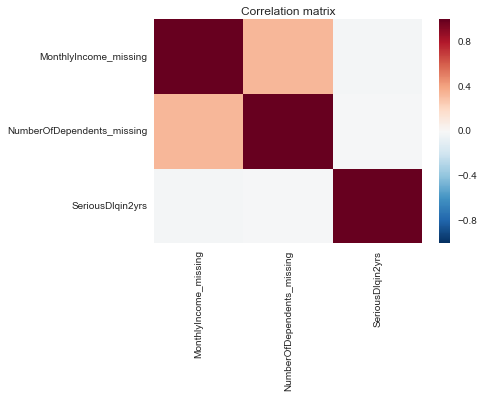

In [17]:
#Are the missing values correlated with our target?
plot_correlations(data[new_columns + ["SeriousDlqin2yrs"]], 'Correlation matrix')

There is no correlation between missing values and our target _SeriousDlqin2yrs_.

----
# Building Features

In [18]:
def discretize_cont_var(df, cont_var, n, dummy_code, drop=False):
    """
    Discretizes  continuous variable.
    In:
        - df: pandas dataframe
        - cont_var: continues variable to be discretized
        - n: number of percentiles
        - dummy_code: (str) to append to dummy columns
        - drop: (bool) to drop continous variable
    Out:
        - df
    """
    step_size = 1/n
    bucket_array = np.arange(0, 1+step_size, step_size)
    
    df[cont_var + dummy_code] = pd.qcut(data[cont_var], bucket_array)
    df = pd.get_dummies(df, columns=[cont_var + dummy_code])
    
    if drop:
        del df[cont_var]
    
    return df

In [19]:
def dummify_var(df, cat_vars, drop=False):
    """
    Takes categorical variable and creates binary/dummy variables from it.
    In:
        - df: pandas dataframe
        - cat_vars: list of categorical variables
        - drop: (bool) whether or not to drop first dummy
    Out:
        - df: pandas dataframe
    """
    return pd.get_dummies(df, columns=cat_vars, drop_first=drop)

In [20]:
# setting test's zipcode as category with attributes from train to ensure 
# same columns in train and test set.
X_test["zipcode"] = X_test["zipcode"].astype('category', categories=X_train.zipcode.unique())

# We will use this code to identify discretized dummy vars
dummy_code = "_XX_disc"

# modifying variables
data = dummify_var(data, ["zipcode"])
data = discretize_cont_var(data, "age", 10, dummy_code)

----
# Training Classifiers

In [22]:
#We will use the preprocessed data as training data
X_train = data.drop(["SeriousDlqin2yrs"], axis=1)

In [23]:
# Do we have similar % of target in train and test?
y_train.value_counts(normalize=True)
y_test.value_counts(normalize=True)

0    0.932886
1    0.067114
Name: SeriousDlqin2yrs, dtype: float64

0    0.933717
1    0.066283
Name: SeriousDlqin2yrs, dtype: float64

In [24]:
def in_bound_test(value, start, end):
    """
    Helper function to recreate discretized dummy
    vars in test set.
    In:
        - value:
        - start:
        - end:
    Out:
        - 1 if value in range; 0 o/w
    """
    if value >= start and value <= end:
        return 1
    else:
        return 0

    
def insert_discretize_quantiles(df, col_to_value_dict, drop_original=False):
    """
    In:
        - df: pandas dataframe
        - col_to_value_dict: (dict) with columns (keys) to be
            created in df as dummy vars according to values
            {original_col: [(dummy_col, start, end),
                            (dummy_col, start, end)]}
        - drop_original: (bool) whether or not to drop original column
                        that discrete dummies are generated from
    Out:
        - df
    """
    for original_col in col_to_value_dict:
        
        list_of_dum_cols = col_to_value_dict[original_col]
        
        for list_of_dum_col in list_of_dum_cols:
            dummy_col, start, end = list_of_dum_col
            df[dummy_col] = df.apply(lambda row: in_bound_test(row[original_col], start, end), axis=1)
        
        if drop_original:
            del df[original_col]
    
    return df

In [25]:
def build_col_to_value_dict(df, dummy_code):
    """
    Function that builds dict with discretized columns
    and their dummy columns with cut-off values.
    In:
        - df: pandas dataframe
        - dummy_code: (str) to append to dummy columns
    Out:
        - dict
    """
    col_to_value_dict = {}
    
    for col in df.columns:
        if dummy_code in col:
            
            start_pos = col.find(dummy_code + "_")
            original_col = (col[:start_pos])
            if not original_col in col_to_value_dict:
                col_to_value_dict[original_col] = []
            
            start_pos = col.find(dummy_code + "_")
            cut_off_vals = col[start_pos + len(dummy_code + "_"):]
            
            start = cut_off_vals[1: cut_off_vals.find(",")]
            if cut_off_vals[0] == "[":
                start = int(start)
            else:
                start = int(start) + 1
            
            end = cut_off_vals[cut_off_vals.find(",") + 1:]
            numbers = re.findall('[\d\.]+', end)
            if numbers:
                end = float(numbers[0])
            else:
                raise ValueError('Could not find number value for end in cut_off_vals.')
            if cut_off_vals[:-1] == ")":
                end -= 1
                
            col_to_value_dict[original_col].append((col, start, end))
    
    return col_to_value_dict        

In [26]:
def create_missing_value_colum_in_testset(traindf, testdf, missing_ind):
    """
    Creates same columns indicating missing values as we 
    have in training set.
    In:
        - traindf: pandas dataframe with training data
        - testdf: pandas dataframe with test data
        - missing_ind: (str) indicates columns that keep track of
            missing data
    Out:
        - df
    """
    for col in traindf.columns:
        
        if col[-len(missing_ind):] == missing_ind:
            
            original_col = col[:col.find(missing_ind)]
            
            new_col = np.zeros(len(testdf), dtype=np.int)
            new_col[testdf[original_col].isnull()] = 1
            testdf[col] = new_col

In [27]:
# ensuring that X_test has the same columns as X_train
X_test = dummify_var(X_test, ["zipcode"])
col_to_value_dict = build_col_to_value_dict(X_train, dummy_code)
X_test = insert_discretize_quantiles(X_test, col_to_value_dict)

#keeping track of missing values (but only in same columns as train data)
create_missing_value_colum_in_testset(X_train, X_test, "_missing")

#fill empty values
X_test = fill_missing_values_with_mean(X_test)